# **Kết nối drive và tải dữ liệu**

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/NLP/'

# **Thêm thư viện**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
# from underthesea import word_tokenize
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.model_selection import train_test_split
# from rouge_score import rouge_scorer
import tensorflow as tf
from keras import layers
from keras.optimizers import Adam
import string
# from pyvi import ViTokenizer
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Đọc dữ liệu**

In [ ]:
data = pd.read_csv(path + "vietnamese_news_20k.csv")
data.columns = ['topic','title','text','summary']
data

,topic,title,text,summary
0,an sinh,Công nhân tại TPHCM được mua hàng Tết lưu động...,Tại buổi họp báo về tình hình kinh tế - xã hội...,(Dân trí) - Liên hiệp Hợp tác xã Thương mại TP...
1,an sinh,"Người dân được nhận 2 tháng lương hưu, trợ cấp...",BHXH Việt Nam có công văn gửi Tổng Công ty Bưu...,(Dân trí) - Để tạo điều kiện cho người hưởng l...
2,an sinh,"Đến tòa ly hôn, lộ chuyện có con khi mới 14 tuổi","Ngày 14/12, thông tin từ VKSND huyện Đắk Song ...",(Dân trí) - Trong quá trình giải quyết ly hôn ...
3,an sinh,Vụ nhân viên bưu điện ăn chặn tiền trợ cấp: Tă...,Sau vụ việc nhân viên bưu điện bị tố ăn bớt ti...,"(Dân trí) - UBND huyện Tuyên Hóa, tỉnh Quảng B..."
4,an sinh,Nữ tiếp viên hàng không bật mí chuyện bị quấy ...,"Chịu trận"" quấy rối Lanelle Henderson (quốc tị...","(Dân trí) - Nghe lời khen của hành khách, nữ t..."
...,...,...,...,...
23243,giải trí,"Khán giả mong gì ở ""Thương ngày nắng về 2"" sau...","""Lối về miền hoa"" là bộ phim nối sóng ""Thương ...","Việc đoàn phim ""Thương ngày nắng về 2"" khai má..."
23244,giải trí,"Queendom trở lại ""gây sốt"" với dàn nghệ sĩ tha...","Ngày 21.2, Mnet đã công bố đội hình đầy đủ các...",Queendom trở lại thu hút sự quan tâm rất lớn c...
23245,giải trí,Nhiệm vụ trọng tâm trong việc mở cửa trở lại d...,Đối với việc mở cửa du lịch quốc tế từ ngày 15...,Trong cuộc họp tổ chức vào sáng ngày 21.2 tại ...
23246,giải trí,"Justin Bieber dương tính với COVID-19, lập tức...","Sáng ngày 21.2, truyền thông nước ngoài đưa ti...","Vì bất ngờ dương tính với COVID-19, Justin Bie..."


<Axes: title={'center': 'Số lượng bài báo theo từng chủ đề'}, xlabel='Topic', ylabel='Count'>

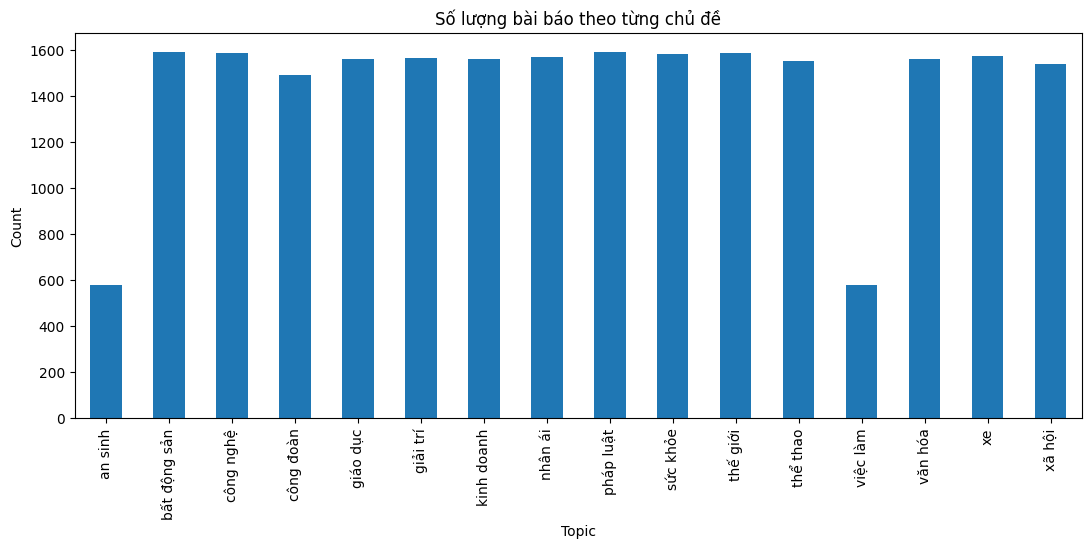

In [ ]:
# Biểu đồ phân phối topic
topic_count = data.groupby('topic')['text'].count()
topic_count.plot(kind='bar', figsize=(13,5), title='Số lượng bài báo theo từng chủ đề', xlabel='Topic', ylabel='Count')

# **I. Pre-trained Model**

In [ ]:
!pip install transformers[torch] datasets evaluate
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00


In [ ]:
# Chọn ra 2 thuộc tính chứa nội dung văn bản và câu tóm tắt
data = pd.read_csv(path + "vietnamese_news_20k.csv")
data.columns = ['topic','title','text','summary']
data = data[['text','summary']]
data

,text,summary
0,Tại buổi họp báo về tình hình kinh tế - xã hội...,(Dân trí) - Liên hiệp Hợp tác xã Thương mại TP...
1,BHXH Việt Nam có công văn gửi Tổng Công ty Bưu...,(Dân trí) - Để tạo điều kiện cho người hưởng l...
2,"Ngày 14/12, thông tin từ VKSND huyện Đắk Song ...",(Dân trí) - Trong quá trình giải quyết ly hôn ...
3,Sau vụ việc nhân viên bưu điện bị tố ăn bớt ti...,"(Dân trí) - UBND huyện Tuyên Hóa, tỉnh Quảng B..."
4,"Chịu trận"" quấy rối Lanelle Henderson (quốc tị...","(Dân trí) - Nghe lời khen của hành khách, nữ t..."
...,...,...
23243,"""Lối về miền hoa"" là bộ phim nối sóng ""Thương ...","Việc đoàn phim ""Thương ngày nắng về 2"" khai má..."
23244,"Ngày 21.2, Mnet đã công bố đội hình đầy đủ các...",Queendom trở lại thu hút sự quan tâm rất lớn c...
23245,Đối với việc mở cửa du lịch quốc tế từ ngày 15...,Trong cuộc họp tổ chức vào sáng ngày 21.2 tại ...
23246,"Sáng ngày 21.2, truyền thông nước ngoài đưa ti...","Vì bất ngờ dương tính với COVID-19, Justin Bie..."


In [ ]:
# Xóa null
data = data.dropna()
data = data.reset_index(drop=True)
# Xóa câu trùng
data = data.drop_duplicates()
data = data.reset_index(drop=True)
# Xóa câu ngắn hơn 200 từ
indexs = data[data['text'].str.split().apply(len) < 200].index
len(indexs)
data = data.drop(indexs)
data = data.reset_index(drop=True)
data.shape

(20792, 2)

In [ ]:
def clean_text(text):
    # Xóa phần text trong dấu () mà không có dấu cách đằng trước
    text = re.sub("\(.*?\)","",text)
    #  Xóa phần text trong dấu () mà có dấu cách đằng trước
    text = re.sub("\s\(.*?\)"," ",text)
    # Xóa \n,\t trong text
    text = re.sub("[\n\t]", " ", text)
    # Thay thế kí tự \xa0 bằng dấu cách
    text = re.sub("(\xa0)"," ", text)
    text = re.sub(r'\u200b',' ',text)
    # Xóa emoji
    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  u"\U0001F300-\U0001F5FF"  u"\U0001F680-\U0001F6FF"  u"\U0001F1E0-\U0001F1FF" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Chuẩn hóa dấu câu cách text một khoảng trắng (optional)
    # text = text.translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation}))
    text = re.sub('[:;]', '', text)
    # sentences = sent_tokenize(text)
    # new = []
    # for sentence in sentences:
    #   # new.append(sentence[:-1] + ' ' + sentence[-1:])
    #   new.append(sentence[:-1])
    # text = ' '.join(new)
    punc = [', ',' , ','<','>','-','|','\"','\'','(',')','!',' % ',' $ ','#','@','^','*',' / ',' . ','“','”']
    for i in punc:
      text = text.replace(i, ' ')
    text = re.sub('\.\.\.', ' ',text)
    # text = re.sub('/', ' / ',text)
    # Đưa về chữ thường
    # text = text.lower()
    # Xóa khoảng trắng thừa trong câu
    text = " ".join(text.split())
    return text

def clean_summary(text):
    # Xóa câu (Dân trí) - ở đầu câu:
    text = text.replace("(Dân trí) - ","")
    # Xóa phần text trong dấu () mà không có dấu cách đằng trước
    text = re.sub("\(.*?\)","",text)
    #  Xóa phần text trong dấu () mà có dấu cách đằng trước
    text = re.sub("\s\(.*?\)"," ",text)
    # Xóa \n,\t trong text
    text = re.sub("[\n\t]", " ", text)
    # Thay thế kí tự \xa0 bằng dấu cách
    text = re.sub("(\xa0)"," ", text)
    text = re.sub(r'\u200b',' ',text)
    # Xóa emoji
    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  u"\U0001F300-\U0001F5FF"  u"\U0001F680-\U0001F6FF"  u"\U0001F1E0-\U0001F1FF" "]+", flags=re.UNICODE)
    emoji_pattern.sub(r'', text)
    # Chuẩn hóa dấu câu cách text một khoảng trắng (optional)
    # text = text.translate(str.maketrans({key: " {0} ".format(key) for key in string.punctuation}))
    text = re.sub('[:;]', '', text)
    # sentences = sent_tokenize(text)
    # new = []
    # for sentence in sentences:
    #   # new.append(sentence[:-1] + ' ' + sentence[-1:])
    #   new.append(sentence[:-1])
    # text = ' '.join(new)
    punc = [', ',' , ','<','>','-','|','\"','\'','(',')','!',' % ',' $ ','#','@','^','*',' / ',' . ','“','”']
    for i in punc:
      text = text.replace(i, ' ')
    text = re.sub('\.\.\.', ' ',text)
    # text = re.sub('/', ' / ',text)
    # Đưa về chữ thường
    # text = text.lower()
    # Xóa khoảng trắng thừa trong câu
    text = " ".join(text.split())
    # Thêm kí tự <start> và <end> vào cuối câu
    # text = 'start ' + text + ' end'
    return text

# Chuyển kiểu dữ liệu thành string
data['text'] = data['text'].apply(str)
data['summary'] = data['summary'].apply(str)
# Tạo cột 2 cột mới cleaned_text và cleaned_summary sau khi đã tiền xử lý
cleaned_text = []
for t in data['text']:
    cleaned_text.append(clean_text(t))

cleaned_summary = []
for t in data['summary']:
    cleaned_summary.append(clean_summary(t))

data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary
data.dropna(axis=0,inplace=True)
data

,text,summary,cleaned_text,cleaned_summary
0,Tại buổi họp báo về tình hình kinh tế - xã hội...,(Dân trí) - Liên hiệp Hợp tác xã Thương mại TP...,Tại buổi họp báo về tình hình kinh tế xã hội c...,Liên hiệp Hợp tác xã Thương mại TPHCM dự kiến ...
1,BHXH Việt Nam có công văn gửi Tổng Công ty Bưu...,(Dân trí) - Để tạo điều kiện cho người hưởng l...,BHXH Việt Nam có công văn gửi Tổng Công ty Bưu...,Để tạo điều kiện cho người hưởng lương hưu trợ...
2,"Ngày 14/12, thông tin từ VKSND huyện Đắk Song ...",(Dân trí) - Trong quá trình giải quyết ly hôn ...,Ngày 14/12 thông tin từ VKSND huyện Đắk Song c...,Trong quá trình giải quyết ly hôn và quyền nuô...
3,Sau vụ việc nhân viên bưu điện bị tố ăn bớt ti...,"(Dân trí) - UBND huyện Tuyên Hóa, tỉnh Quảng B...",Sau vụ việc nhân viên bưu điện bị tố ăn bớt ti...,UBND huyện Tuyên Hóa tỉnh Quảng Bình đã yêu cầ...
4,"Chịu trận"" quấy rối Lanelle Henderson (quốc tị...","(Dân trí) - Nghe lời khen của hành khách, nữ t...",Chịu trận quấy rối Lanelle Henderson là một cự...,Nghe lời khen của hành khách nữ tiếp viên hàng...
...,...,...,...,...
20787,"""Lối về miền hoa"" là bộ phim nối sóng ""Thương ...","Việc đoàn phim ""Thương ngày nắng về 2"" khai má...",Lối về miền hoa là bộ phim nối sóng Thương ngà...,Việc đoàn phim Thương ngày nắng về 2 khai máy ...
20788,"Ngày 21.2, Mnet đã công bố đội hình đầy đủ các...",Queendom trở lại thu hút sự quan tâm rất lớn c...,Ngày 21.2 Mnet đã công bố đội hình đầy đủ các ...,Queendom trở lại thu hút sự quan tâm rất lớn c...
20789,Đối với việc mở cửa du lịch quốc tế từ ngày 15...,Trong cuộc họp tổ chức vào sáng ngày 21.2 tại ...,Đối với việc mở cửa du lịch quốc tế từ ngày 15...,Trong cuộc họp tổ chức vào sáng ngày 21.2 tại ...
20790,"Sáng ngày 21.2, truyền thông nước ngoài đưa ti...","Vì bất ngờ dương tính với COVID-19, Justin Bie...",Sáng ngày 21.2 truyền thông nước ngoài đưa tin...,Vì bất ngờ dương tính với COVID 19 Justin Bieb...


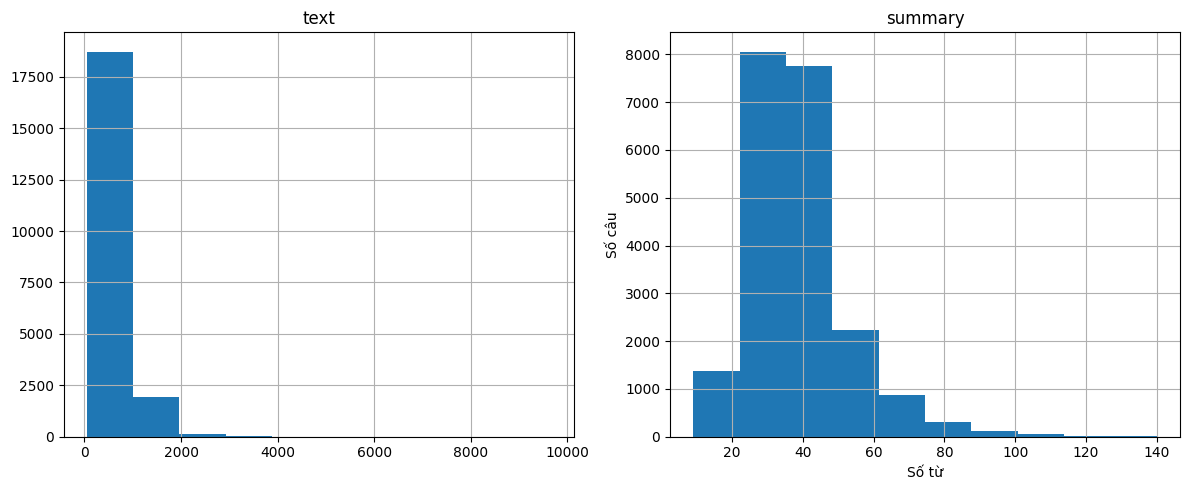

max_len_text = 811
max_len_summary = 47


In [ ]:
# Xem số lượng từ trong 1 câu
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

pd.DataFrame({'text':text_word_count, 'summary':summary_word_count}).hist(bins = 10, figsize=(12,5))
plt.xlabel('Số từ')
plt.ylabel('Số câu')
plt.tight_layout()
plt.show()
# Chọn max_len phù hợp để padding text
max_len_text = round(pd.DataFrame(text_word_count, columns=['word_count']).describe(percentiles=[0.5, 0.7, 0.8, 0.9,0.95]).loc['80%']['word_count'])
print(f'max_len_text = {max_len_text}')
# Chọn max_len phù hợp để padding summary
max_len_summary = round(pd.DataFrame(summary_word_count, columns=['word_count']).describe(percentiles=[0.5, 0.7, 0.8, 0.9, 0.95]).loc['80%']['word_count'])
print(f'max_len_summary = {max_len_summary}')

In [ ]:
# Tìm số từ lớn nhất của 1 text, summary

print('Text dài nhất có :', max(text_word_count), ' từ')
print('Summary dài nhất có :', max(summary_word_count), ' từ')

Text dài nhất có : 9647  từ
Summary dài nhất có : 140  từ


In [ ]:
# Tìm số từ nho nhat của 1 text, summary

print('Text ngan nhất có :', min(text_word_count), ' từ')
print('Summary ngan nhất có :', min(summary_word_count), ' từ')

Text ngan nhất có : 48  từ
Summary ngan nhất có : 9  từ


In [ ]:
# Chia dữ liệu theo tỉ lệ 8 : 1 : 1
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.1,random_state=30)
train_data, val_data = train_test_split(train_data, test_size=0.1,random_state=30)

# **1. ViT5**

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, TrainingArguments, Seq2SeqTrainingArguments
from torch.utils.data import DataLoader

checkpoint = "VietAI/vit5-base-vietnews-summarization"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
model.to('cuda')

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["inputs"], max_length=max_len_text, truncation=True, padding=True
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["labels"], max_length=max_len_summary, truncation=True, padding=True
        )
    model_inputs['labels'] = labels['input_ids']
    model_inputs['input_ids'] = model_inputs['input_ids']
    return model_inputs

# Delete later
input_lines = train_data['cleaned_text'].tolist()
label_lines = train_data['cleaned_summary'].tolist()

dict_obj = {'inputs': input_lines, 'labels': label_lines}
dataset = Dataset.from_dict(dict_obj)
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=4)

tokenizer_config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/16840 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")


training_args = Seq2SeqTrainingArguments("tmp/",do_train=True,do_eval=True,num_train_epochs=3,learning_rate=1e-4,warmup_ratio=0.05,weight_decay=0.1,
        per_device_train_batch_size=2,per_device_eval_batch_size=2,logging_dir='./log',group_by_length=True,save_strategy="epoch",save_total_limit=1,fp16=True)

trainer = Seq2SeqTrainer(model=model,args=training_args,train_dataset=tokenized_datasets,data_collator=data_collator,)

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,3.726800
1000,2.051300
1500,2.152600
2000,2.145500
2500,2.174500
3000,2.134500
3500,2.113800
4000,2.038300
4500,2.056700
5000,2.067600


TrainOutput(global_step=25260, training_loss=1.5513030848801372, metrics={'train_runtime': 9655.6495, 'train_samples_per_second': 5.232, 'train_steps_per_second': 2.616, 'total_flos': 4.87305706715136e+16, 'train_loss': 1.5513030848801372, 'epoch': 3.0})

In [ ]:
# Lưu mô hình đến kho huggingface
!huggingface-cli login
trainer.push_to_hub('llewisd/my_vit5')


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

'https://huggingface.co/llwisd/tmp/tree/main/'

In [ ]:
# Inference
from datasets import load_metric
metric = load_metric("rouge")

# Delete later
input_lines = test_data['cleaned_text'].tolist()
label_lines = test_data['cleaned_summary'].tolist()

dict_obj = {'inputs': input_lines, 'labels': label_lines}

dataset = Dataset.from_dict(dict_obj)
test_tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=4)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")
path = "/content/tmp/"
checkpoint_file = os.listdir(path)
model = AutoModelForSeq2SeqLM.from_pretrained(f"/content/tmp/checkpoint-25260")
model.to('cuda')

Map (num_proc=4):   0%|          | 0/2080 [00:00<?, ? examples/s]

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
import torch
import numpy as np
metrics = load_metric('rouge')

max_target_length = max_len_summary
dataloader = torch.utils.data.DataLoader(test_tokenized_datasets, collate_fn=data_collator, batch_size=64)

predictions = []
references = []
for i, batch in enumerate(dataloader):
  outputs = model.generate(
      input_ids=batch['input_ids'].to('cuda'),
      max_length=max_target_length,
      attention_mask=batch['attention_mask'].to('cuda'),
  )
  with tokenizer.as_target_tokenizer():
    outputs = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in outputs]

    labels = np.where(batch['labels'] != -100,  batch['labels'], tokenizer.pad_token_id)
    actuals = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in labels]
  predictions.extend(outputs)
  references.extend(actuals)
  metrics.add_batch(predictions=outputs, references=actuals)


[{k: v.mid.fmeasure} for k,v in metrics.compute(predictions=predictions, references=references).items()]

[{'rouge1': 0.5871478126340106},
 {'rouge2': 0.28167724806047023},
 {'rougeL': 0.3888405410395188},
 {'rougeLsum': 0.38857193392434763}]

In [ ]:
for i,j in zip(references,predictions):
  print('Actual : ', i)
  print('Summary : ', j)
  print(' - ' * 100)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Summary :  Vân Vân Đông Phong gặp biến cố tình cảm khi mới nhận lời yêu.
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Actual :  Mắc chứng bại não bẩm sinh thể co cứng thế nhưng Nguyễn Đức Thuận  nhân vật của Trạm yêu thương số 19 lại có một niềm đam mê mãnh liệt với toán và tin học.
Summary :  MC Minh Hằng đã có những chia sẻ thú vị về hành trình theo đuổi ước mơ trở thành luật sư của Thuận.
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  

# **2. BartPho**

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, TrainingArguments, Seq2SeqTrainingArguments
from torch.utils.data import DataLoader

checkpoint = "vinai/bartpho-word-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
model.to('cuda')

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["inputs"], max_length=max_len_text, truncation=True, padding=True
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["labels"], max_length=max_len_summary, truncation=True, padding=True
        )
    model_inputs['labels'] = labels['input_ids']
    model_inputs['input_ids'] = model_inputs['input_ids']
    return model_inputs

# Delete later
input_lines = train_data['cleaned_text'].tolist()
label_lines = train_data['cleaned_summary'].tolist()

dict_obj = {'inputs': input_lines, 'labels': label_lines}
dataset = Dataset.from_dict(dict_obj)
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=4)

config.json:   0%|          | 0.00/898 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/600M [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/16840 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")


training_args = Seq2SeqTrainingArguments("tmp/",do_train=True,do_eval=False,num_train_epochs=3,learning_rate=1e-4,warmup_ratio=0.05,weight_decay=0.01,
        per_device_train_batch_size=2,per_device_eval_batch_size=2,logging_dir='./log',group_by_length=True,save_strategy="epoch",save_total_limit=1)

trainer = Seq2SeqTrainer(model=model,args=training_args,train_dataset=tokenized_datasets,data_collator=data_collator,)

trainer.train()

Step,Training Loss
500,3.919100
1000,3.145600
1500,3.228100
2000,3.140600
2500,3.074500
3000,2.983700
3500,2.918600
4000,2.832100
4500,2.822300
5000,2.785100


TrainOutput(global_step=25260, training_loss=2.1577448587425154, metrics={'train_runtime': 6932.9883, 'train_samples_per_second': 7.287, 'train_steps_per_second': 3.643, 'total_flos': 2.439719214465024e+16, 'train_loss': 2.1577448587425154, 'epoch': 3.0})

In [ ]:
# Lưu mô hình đến kho huggingface
!huggingface-cli login
trainer.push_to_hub('llewisd/my_bartpho')


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

model.safetensors:   0%|          | 0.00/600M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

'https://huggingface.co/llwisd/tmp/tree/main/'

In [ ]:
# Inference
from datasets import load_metric
metric = load_metric("rouge")

# Delete later
input_lines = test_data['cleaned_text'].tolist()
label_lines = test_data['cleaned_summary'].tolist()

dict_obj = {'inputs': input_lines, 'labels': label_lines}

dataset = Dataset.from_dict(dict_obj)
test_tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=4)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")
path = "/content/tmp/"
checkpoint_file = os.listdir(path)
model = AutoModelForSeq2SeqLM.from_pretrained(f"/content/tmp/checkpoint-25260")
model.to('cuda')

Map (num_proc=4):   0%|          | 0/2080 [00:00<?, ? examples/s]

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(64001, 768, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(64001, 768, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,)

In [ ]:
import torch
import numpy as np
metrics = load_metric('rouge')

max_target_length = max_len_summary
dataloader = torch.utils.data.DataLoader(test_tokenized_datasets, collate_fn=data_collator, batch_size=64)

predictions = []
references = []
for i, batch in enumerate(dataloader):
  outputs = model.generate(
      input_ids=batch['input_ids'].to('cuda'),
      max_length=max_target_length,
      attention_mask=batch['attention_mask'].to('cuda'),
  )
  with tokenizer.as_target_tokenizer():
    outputs = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in outputs]

    labels = np.where(batch['labels'] != -100,  batch['labels'], tokenizer.pad_token_id)
    actuals = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in labels]
  predictions.extend(outputs)
  references.extend(actuals)
  metrics.add_batch(predictions=outputs, references=actuals)


[{k: v.mid.fmeasure} for k,v in metrics.compute(predictions=predictions, references=references).items()]

[{'rouge1': 0.5753343165290765},
 {'rouge2': 0.25810934377969363},
 {'rougeL': 0.3695975908729976},
 {'rougeLsum': 0.3695746948154818}]

In [ ]:
for i,j in zip(references,predictions):
  print('Actual : ', i)
  print('Summary : ', j)
  print(' - ' * 100)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Summary :  Sau khi bị cô gái cũ ở quê lên thành phố đánh ghen Vân Vân và Phong đã có những chia sẻ thẳng thắn về mối quan hệ giữa mình.
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Actual :  Mắc chứng bại não bẩm sinh thể co cứng thế nhưng Nguyễn Đức Thuận – nhân vật của Trạm yêu thương số 19 lại có một niềm đam mê mãnh liệt với toán và tin học.
Summary :  MC Minh Hằng cho biết trong chương trình Những ngày học mẫu giáo mẹ đã đồng hành cùng Thuận suốt năm học mẫu giáo mẹ đã nuôi dạy con gái bị bại não thể co cứng không làm được gì khiến em bị tổn
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -

# **3. mT5**

In [ ]:
!pip install transformers[sentencepiece] datasets evaluate
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, TrainingArguments, Seq2SeqTrainingArguments
from torch.utils.data import DataLoader

checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
model.to('cuda')

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["inputs"], max_length=max_len_text, truncation=True, padding=True
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["labels"], max_length=max_len_summary, truncation=True, padding=True
        )
    model_inputs['labels'] = labels['input_ids']
    model_inputs['input_ids'] = model_inputs['input_ids']
    return model_inputs

# Delete later
input_lines = train_data['cleaned_text'].tolist()
label_lines = train_data['cleaned_summary'].tolist()

dict_obj = {'inputs': input_lines, 'labels': label_lines}
dataset = Dataset.from_dict(dict_obj)
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=4)

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/16840 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")


training_args = Seq2SeqTrainingArguments("tmp/",do_train=True,do_eval=False,num_train_epochs=3,learning_rate=1e-4,warmup_ratio=0.05,weight_decay=0.01,
        per_device_train_batch_size=2,per_device_eval_batch_size=2,logging_dir='./log',group_by_length=True,save_strategy="epoch",save_total_limit=1)

trainer = Seq2SeqTrainer(model=model,args=training_args,train_dataset=tokenized_datasets,data_collator=data_collator,)

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,15.691600
1000,3.576800
1500,3.031200
2000,2.743700
2500,2.590100
3000,2.457800
3500,2.391000
4000,2.307600
4500,2.282500
5000,2.211900


TrainOutput(global_step=25260, training_loss=2.278516332969152, metrics={'train_runtime': 7693.0735, 'train_samples_per_second': 6.567, 'train_steps_per_second': 3.283, 'total_flos': 4.23120786812928e+16, 'train_loss': 2.278516332969152, 'epoch': 3.0})

In [ ]:
# Lưu mô hình đến kho huggingface
!huggingface-cli login
trainer.push_to_hub('llwisd/my_mt5')


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

'https://huggingface.co/llwisd/tmp/tree/main/'

In [ ]:
# Inference
from datasets import load_metric
metric = load_metric("rouge")

# Delete later
input_lines = test_data['cleaned_text'].tolist()
label_lines = test_data['cleaned_summary'].tolist()

dict_obj = {'inputs': input_lines, 'labels': label_lines}

dataset = Dataset.from_dict(dict_obj)
test_tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=4)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")
path = "/content/tmp/"
checkpoint_file = os.listdir(path)
model = AutoModelForSeq2SeqLM.from_pretrained(f"/content/tmp/checkpoint-25260")
model.to('cuda')

Map (num_proc=4):   0%|          | 0/2080 [00:00<?, ? examples/s]

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

In [ ]:
import torch
import numpy as np
metrics = load_metric('rouge')

max_target_length = max_len_summary
dataloader = torch.utils.data.DataLoader(test_tokenized_datasets, collate_fn=data_collator, batch_size=64)

predictions = []
references = []
for i, batch in enumerate(dataloader):
  outputs = model.generate(
      input_ids=batch['input_ids'].to('cuda'),
      max_length=max_target_length,
      attention_mask=batch['attention_mask'].to('cuda'),
  )
  with tokenizer.as_target_tokenizer():
    outputs = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in outputs]

    labels = np.where(batch['labels'] != -100,  batch['labels'], tokenizer.pad_token_id)
    actuals = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in labels]
  predictions.extend(outputs)
  references.extend(actuals)
  metrics.add_batch(predictions=outputs, references=actuals)


[{k: v.mid.fmeasure} for k,v in metrics.compute(predictions=predictions, references=references).items()]

[{'rouge1': 0.5074374683000028},
 {'rouge2': 0.19307378809515846},
 {'rougeL': 0.33606384206062934},
 {'rougeLsum': 0.336001444073226}]

In [ ]:
for i,j in zip(references,predictions):
  print('Actual : ', i)
  print('Summary : ', j)
  print(' - ' * 100)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Summary :  Bách và Vân đã gặp biến cố lớn lớn nhưng tình cảm của Vân Vân và Bách đã g
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Actual :  Mắc chứng bại não bẩm sinh thể co cứng thế nhưng Nguyễn Đức Thuận – nhân vật của Trạm yêu thương 
Summary :  Không giới thiệu khách mời MC Minh Hằng nói về một tập giấy khen cầm trên tay và chủ nhân của những
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Actual :  Vinhomes sắp ra mắt ZR2 th

# **II. Error Analyst**

**a) Overlaping word between text and summary**

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
result1 = {}
text_list = []
summary_list = []
score_list = []
for i,j in zip(test_data['cleaned_text'].tolist(), test_data['cleaned_summary'].tolist()):
    rouge = Rouge(['rouge-2'])
    scores = rouge.get_scores(j, i)[0]['rouge-2']['f']
    scores = round(scores, 4)
    text_list.append(i)
    summary_list.append(j)
    score_list.append(scores)
result1.update({'text': text_list, 'summary': summary_list, 'Overlap': score_list})
df1 = pd.DataFrame.from_dict(result1)
df1 = df1.sort_values(by=['Overlap'], ascending=False)
df1

,text,summary,Overlap
407,BHXH Việt Nam trả lời Về thời gian hưởng chế đ...,Chị Hồng Hạnh hỏi Tôi đóng BHXH bắt buộc được ...,0.425963
1607,Sáng ngày 30 Tết Nguyên đán Canh Tí Phó Thủ tư...,Đi thăm cán bộ bộ nhân viên y tế tại Bệnh viện...,0.385246
596,Apple vừa phát hành bản cập nhật iOS 17.1.2 và...,Apple cho biết bản cập nhật iOS 17.1.2 sẽ khắc...,0.357488
1495,Theo đánh giá của Sở GDĐT Thanh Hóa kết thúc 2...,Kết thúc 2 ngày của kỳ thi THPT quốc gia năm 2...,0.349515
771,Ông Nguyễn Hà cho biết ông tốt nghiệp thạc sĩ ...,Không thực hiện chế độ tập sự khi tuyển dụng c...,0.328889
...,...,...,...
587,I wish I could show my immense gratitude to yo...,Ngày nhà giáo Việt Nam 20.11 là dịp để các thế...,0.006849
1724,PENCAK SILAT 10h30 Dines Dumaan vs Nguyễn Đình...,Ngày thi đấu chính thức đầu tiên của SEA Games...,0.005935
940,Những ngày thôn Hạ Lôi cách ly người ta vẫn th...,Đến tận bây giờ dù đã ở tuổi gần đất xa trời ô...,0.005025
951,Nếu họ thực sự gắn kết và hiểu nhau hơn nữa tô...,Liverpool đang rất mạnh nhưng dường như họ cũn...,0.002594


**b) Calculate ROUGE-L**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
checkpoint = "llwisd/my_vit5"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/793 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [ ]:
def summarize(text, model, tokenizer):
  encoding = tokenizer(text, return_tensors="pt", max_length=811, truncation=True, padding=True)
  input_ids, attention_masks = encoding["input_ids"], encoding["attention_mask"]
  outputs = model.generate(
      input_ids=input_ids.to('cuda'), attention_mask=attention_masks.to('cuda'),
      max_length=47
  )
  for output in outputs:
      line = tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
  return line

model.to('cuda')
result_dict = {}
score_rouge_list = []
output_predict = []
text_list = []
summary_list = []
score_list = []
for i,j,k in zip(df1['text'].tolist(), df1['summary'].tolist(), df1['Overlap'].tolist()):
  text_predict = summarize(i, model, tokenizer)
  rouge = Rouge(['rouge-l'])
  scores = rouge.get_scores(text_predict, j)[0]['rouge-l']['f']
  text_list.append(i)
  summary_list.append(j)
  output_predict.append(text_predict)
  score_list.append(k)
  score_rouge_list.append(scores)
result_dict.update({'text': text_list, 'summary': summary_list, 'output': output_predict ,'Overlap': score_list, 'ROUGE-L': score_rouge_list})
df2 = pd.DataFrame.from_dict(result_dict)
df2

,text,summary,output,Overlap,ROUGE-L
0,BHXH Việt Nam trả lời Về thời gian hưởng chế đ...,Chị Hồng Hạnh hỏi Tôi đóng BHXH bắt buộc được ...,Người lao động tại đơn vị có đủ điều kiện hưởn...,0.425963,0.381818
1,Sáng ngày 30 Tết Nguyên đán Canh Tí Phó Thủ tư...,Đi thăm cán bộ bộ nhân viên y tế tại Bệnh viện...,Phó Thủ tướng Vũ Đức Đam đã đến thăm và tặng q...,0.385246,0.264706
2,Apple vừa phát hành bản cập nhật iOS 17.1.2 và...,Apple cho biết bản cập nhật iOS 17.1.2 sẽ khắc...,Bản cập nhật iOS 17.1.2 sẽ khắc phục các lỗ hổ...,0.357488,0.941176
3,Theo đánh giá của Sở GDĐT Thanh Hóa kết thúc 2...,Kết thúc 2 ngày của kỳ thi THPT quốc gia năm 2...,Ngày 23.6 Sở GDĐT Thanh Hóa đã công bố kết thú...,0.349515,0.333333
4,Ông Nguyễn Hà cho biết ông tốt nghiệp thạc sĩ ...,Không thực hiện chế độ tập sự khi tuyển dụng c...,Ông Nguyễn Hà sinh năm 1971 trúng tuyển Tổng c...,0.328889,0.215385
...,...,...,...,...,...
2075,I wish I could show my immense gratitude to yo...,Ngày nhà giáo Việt Nam 20.11 là dịp để các thế...,Trong một năm đầy thăng hoa của sự nghiệp và s...,0.006849,0.061538
2076,PENCAK SILAT 10h30 Dines Dumaan vs Nguyễn Đình...,Ngày thi đấu chính thức đầu tiên của SEA Games...,Ngày thi đấu chính thức thứ năm của SEA Games ...,0.005935,0.357143
2077,Những ngày thôn Hạ Lôi cách ly người ta vẫn th...,Đến tận bây giờ dù đã ở tuổi gần đất xa trời ô...,Ở xóm Chợ xã Hà Tĩnh của cụ ông Trần Văn Tân l...,0.005025,0.138889
2078,Nếu họ thực sự gắn kết và hiểu nhau hơn nữa tô...,Liverpool đang rất mạnh nhưng dường như họ cũn...,Ở mùa giải này Liverpool đã giành chiến thắng ...,0.002594,0.108108


In [ ]:
df3 = df2.sample(50)
df3 = df3.sort_values(by=['Overlap'], ascending=True)
df3

,text,summary,output,Overlap,ROUGE-L
2003,Không sử dụng đèn chiếu sáng trong thời gian ...,Tại Việt Nam xe máy là phương tiện tham gia gi...,Phạt tiên không đúng quy định khi tham gia gia...,0.019560,0.158730
1993,Inter Milan đang có phong độ rất ấn tượng với ...,Trận đấu giữa Inter Milan và AS Roma thuộc vòn...,Inter Milan đã có một ngày thi đấu ấn tượng vớ...,0.020151,0.163265
1899,Những ngày qua Khổng Tú Quỳnh nhận được sự qua...,Sau nhiều năm hoạt động trong làng giải trí cũ...,Ở tuổi 32 nữ ca sĩ Khổng Tú Quỳnh vẫn được nhi...,0.027444,0.148148
1873,Hẹn hò chốn công sở đang là tâm điểm chú ý của...,Nhiều bộ phim gây bão màn ảnh lập kỷ lục ratin...,Hẹn hò chốn công sở luôn là một trong những ph...,0.028892,0.243902
1856,Với Kia Seltos đây là lần điều chỉnh giá thứ 2...,Trên trang chủ của Kia Việt Nam đã cập nhật lạ...,Trong tháng 5 vừa qua Kia đã tăng giá bán của ...,0.029762,0.266667
1816,Sáng 2.4 Phó Chủ tịch UBND tỉnh Bình Định Trần...,Đây là lần thứ 2 UBND tỉnh Bình Định tổ chức đ...,Trước phản đối của người dân về Dự án Nhà máy ...,0.031915,0.144928
1810,Toyota Altis Vios giảm giá Thời điểm cuối năm ...,Năm nay là một năm khá khó khăn đối với thị tr...,Trong tháng 10 các hãng xe ôtô liên tục tung r...,0.032154,0.214286
1799,Thông tin về phạt nguội Phạt nguội là hình thứ...,Các tài xế có thể dễ dàng tra cứu thông tin ph...,Dưới đây là hướng dẫn xử lý vi phạm giao thông...,0.033012,0.235294
1743,Trước tình hình này Thủ tướng đã cử Phó Thủ tư...,Tại phiên họp Chính phủ thường kỳ tháng 7.2017...,Yên Bái Chiều 30.8 Thủ tướng Chính phủ Nguyễn ...,0.036036,0.312500
1736,Ngày 28.4 công ty Acecook Việt Nam công bố thô...,Đội tuyển Việt Nam đội tuyển nữ và U23 Việt Na...,Công ty Acecook Việt Nam tiếp tục là nhà tài t...,0.036290,0.280000


Text(0.5, 1.0, 'Affection of Overlap to result')

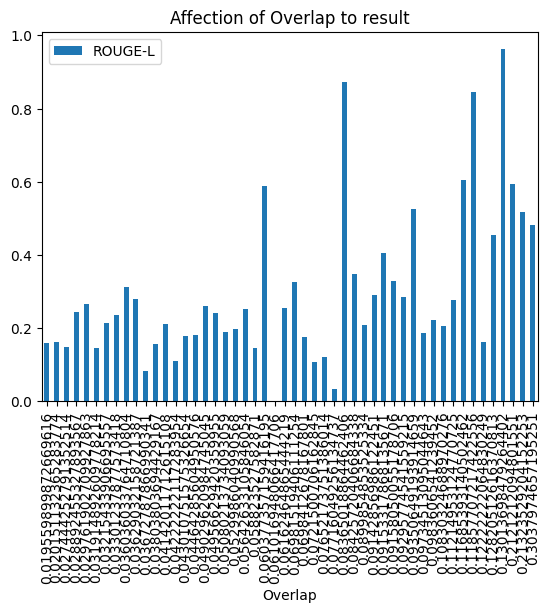

In [ ]:
df3.plot(x='Overlap',y='ROUGE-L',kind='bar')
plt.title('Affection of Overlap to result')

-> Evaluation : In above figure, ROUGE score increase when overlap is high